In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from operator import methodcaller
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
df_train = pd.read_csv('dataset/train.csv', dtype=str)
df_test = pd.read_csv('dataset/test.csv', dtype=str)

In [3]:
def process_images(dataset):
    dataset = dataset.apply(' '.join, axis=1)
    dataset = list(map(methodcaller('split', ' '), dataset))    
    dataset = np.array(np.reshape(dataset, (-1, 28, 28, 1)), dtype=int) / 255.0
    images = []
    for image in dataset:
        zeros = np.zeros((32, 32, 1))
        zeros[2:30,2:30,:] = image
        images.append(zeros)
    
    return np.array(images)

In [4]:
X = process_images(df_train[df_train.columns.values[1:]])
y = df_train['label']

X_test = process_images(df_test)

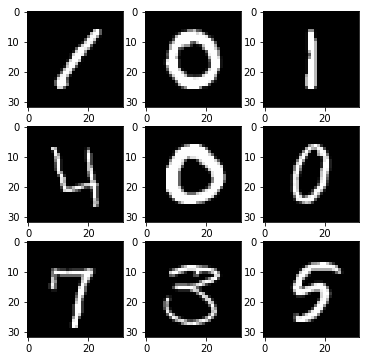

In [5]:
fig, ax = plt.subplots(3, 3, figsize=(6, 6))
e = 0

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(X[e].reshape(32, 32), cmap='gray')
        e += 1

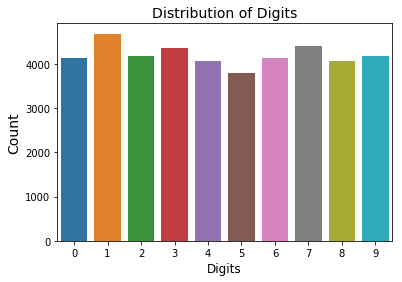

In [6]:
sns.countplot(x='label', data=df_train)
plt.title('Distribution of Digits', fontsize=14)
plt.xlabel('Digits', fontsize=12)
plt.ylabel('Count', fontsize=14)
plt.show()

In [7]:
y = y.values.reshape(-1, 1)

In [8]:
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=3)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [11]:
model = Sequential([
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)),
    AvgPool2D(),
    
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AvgPool2D(),
    
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    Dense(units=10, activation = 'softmax'),
])
model.build()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [12]:
adam = Adam(lr=5e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [13]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience=3, 
                              verbose=1, 
                              factor=0.2, 
                              min_lr=1e-6)

In [14]:
BATCH_SIZE = 64
EPOCHS = 40

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_val.shape[0]//BATCH_SIZE

history = model.fit(X_train,
                   y_train,
                   batch_size=64,
                   epochs=EPOCHS,
                   steps_per_epoch=steps_per_epoch,
                   validation_steps=validation_steps,
                   validation_data=(X_val, y_val),
                   callbacks=[reduce_lr])

Train on 37800 samples, validate on 4200 samples
Epoch 1/40
36968/37800 [============================>.] - ETA: 0s - loss: 0.0333 - accuracy: 0.9895
Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
37416/37800 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9959
Epoch 00016: ReduceLROnPlateau reducing learning rate to 2.0000000949949027e-05.
37416/37800 [============================>.] - ETA: 0s - loss: 0.0113 - accuracy: 0.9974
Epoch 00019: ReduceLROnPlateau reducing learning rate to 4.000000262749381e-06.
37672/37800 [============================>.] - ETA: 0s - loss: 0.0103 - accuracy: 0.9978
Epoch 00025: ReduceLROnPlateau reducing learning rate to 1e-06.
37736/37800 [============================>.] - ETA: 0s - loss: 0.0101 - accuracy: 0.9979 - val_loss: 0.0511 - val_accuracy: 0.9839

In [15]:
print(X_train.shape, steps_per_epoch)

(37800, 32, 32, 1) 590


In [16]:
model.save('model.h5')

In [17]:
prediction = model.predict(X_test)

In [18]:
submission = pd.read_csv('dataset/sample_submission.csv')

In [19]:
submission['Label'] = encoder.inverse_transform(prediction)

In [20]:
submission.to_csv('result.csv', index=False)

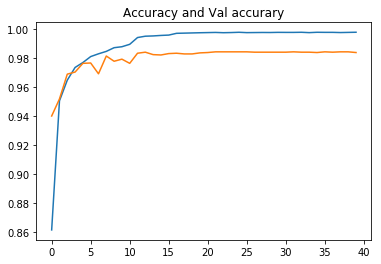

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy and Val accurary')
plt.show()

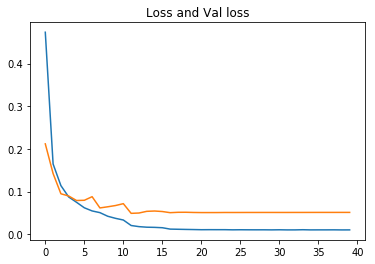

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss and Val loss')
plt.show()